# Advanced Medical Image Analysis
### Tumor Masks, ROI Extraction, Histogram Analysis, and Statistical Measurements

This notebook demonstrates advanced techniques for analyzing medical images, with particular focus on:
- Understanding and working with tumor masks
- Extracting regions of interest (ROIs)
- Performing histogram analysis
- Calculating statistical parameters

## 1. Import Required Libraries and Setup

In [15]:
# Install required packages if they're not already installed
import sys
import subprocess

def install_if_needed(package):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} installed successfully!")

# Install required packages
install_if_needed('nibabel')
install_if_needed('scikit-image')
install_if_needed('matplotlib')
install_if_needed('scipy')
install_if_needed('pandas')
install_if_needed('seaborn')

nibabel is already installed.
Installing scikit-image...
scikit-image installed successfully!
matplotlib is already installed.
scipy is already installed.
pandas is already installed.
seaborn is already installed.


In [16]:
# Fix the mpl_toolkits.mplot_3d import
from mpl_toolkits.mplot_3d import Axes3D  # Uncomment this line

# Add IPython display import for the display() function
from IPython.display import display

ModuleNotFoundError: No module named 'mpl_toolkits.mplot_3d'

In [19]:
# Import necessary libraries
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os


from scipy import stats
from skimage import measure, filters, morphology
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
#from mpl_toolkits.mplot_3d import Axes3D
from matplotlib.ticker import PercentFormatter

# For inline plotting in Jupyter notebook
%matplotlib inline

# Set some plotting defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('ggplot')

# Create a custom colormap for overlaying ROIs
colors = [(0, 0, 0, 0), (1, 0, 0, 0.7)]  # Transparent to semi-transparent red
red_cmap = LinearSegmentedColormap.from_list('custom_red', colors, N=256)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data and Understand Masks

Medical image masks are binary images that segment regions of interest (like tumors) from the background. 
Masks typically have the same dimensions as the original image, with values of 1 (or another non-zero value) 
representing the region of interest and 0 representing the background.

In this section, we'll:
1. Load our medical image datasets
2. Examine the tumor mask
3. Understand how masks represent regions of interest

In [20]:
# Define paths to our datasets
ivim_path = '/Users/ayush/Desktop/project-internsip/Datasets/ivim_chest.nii.gz'
tumor_path = '/Users/ayush/Desktop/project-internsip/Datasets/tumor.nii.gz'

def load_nifti_data(file_path, verbose=True):
    """
    Load a NIfTI file and return both the image object and data array
    
    Parameters:
        file_path (str): Path to the NIfTI file
        verbose (bool): Whether to print information about the loaded data
        
    Returns:
        tuple: (nib.Nifti1Image, numpy.ndarray) - The NIfTI image object and its data
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None, None
    
    # Load the NIfTI file
    img = nib.load(file_path)
    data = img.get_fdata()
    
    if verbose:
        print(f"\nLoaded: {os.path.basename(file_path)}")
        print(f"• Shape: {data.shape}")
        print(f"• Data type: {data.dtype}")
        print(f"• Value range: [{data.min():.3f}, {data.max():.3f}]")
        
        # Print dimensionality information
        if len(data.shape) == 3:
            print(f"• This is a 3D volume with dimensions: {data.shape[0]}×{data.shape[1]}×{data.shape[2]} voxels")
        elif len(data.shape) == 4:
            print(f"• This is a 4D dataset with dimensions: {data.shape[0]}×{data.shape[1]}×{data.shape[2]} voxels × {data.shape[3]} volumes")
    
    return img, data

# Load the datasets
print("=" * 70)
print("LOADING DATASETS".center(70))
print("=" * 70)

ivim_img, ivim_data = load_nifti_data(ivim_path)
tumor_img, tumor_data = load_nifti_data(tumor_path)

# Display additional information about the tumor mask
print("\n" + "=" * 70)
print("TUMOR MASK INFORMATION".center(70))
print("=" * 70)

# Check if the tumor data is binary (a mask)
unique_values = np.unique(tumor_data)
print(f"• Unique values in tumor data: {unique_values}")

# Count non-zero voxels (potential tumor regions)
non_zero = np.count_nonzero(tumor_data)
total_voxels = tumor_data.size
percentage = (non_zero / total_voxels) * 100

print(f"• Non-zero voxels: {non_zero:,} out of {total_voxels:,} total voxels")
print(f"• Percentage of mask volume: {percentage:.4f}%")

# If the tumor data contains values other than 0 and 1, it might not be a binary mask
if not np.array_equal(unique_values, [0, 1]) and not np.array_equal(unique_values, [0.0, 1.0]):
    print("\nNote: The tumor data is not strictly binary (0 and 1 only).")
    print("It may be a probability map or segmentation with multiple labels.")
else:
    print("\nThe tumor data is a binary mask, suitable for ROI extraction.")

                           LOADING DATASETS                           

Loaded: ivim_chest.nii.gz
• Shape: (224, 224, 67, 9)
• Data type: float64
• Value range: [0.000, 3827.761]
• This is a 4D dataset with dimensions: 224×224×67 voxels × 9 volumes

Loaded: tumor.nii.gz
• Shape: (192, 192, 64)
• Data type: float64
• Value range: [0.000, 1.000]
• This is a 3D volume with dimensions: 192×192×64 voxels

                        TUMOR MASK INFORMATION                        
• Unique values in tumor data: [0. 1.]
• Non-zero voxels: 2,170 out of 2,359,296 total voxels
• Percentage of mask volume: 0.0920%

The tumor data is a binary mask, suitable for ROI extraction.


## 3. Create and Apply Masks

In this section, we'll:
1. Demonstrate how to create a binary mask from an image
2. Apply the mask to extract regions of interest
3. Visualize the masked regions

We'll use the tumor mask to isolate the tumor regions from the IVIM data.

Best slice for viewing the tumor: 15

Displaying the tumor mask:


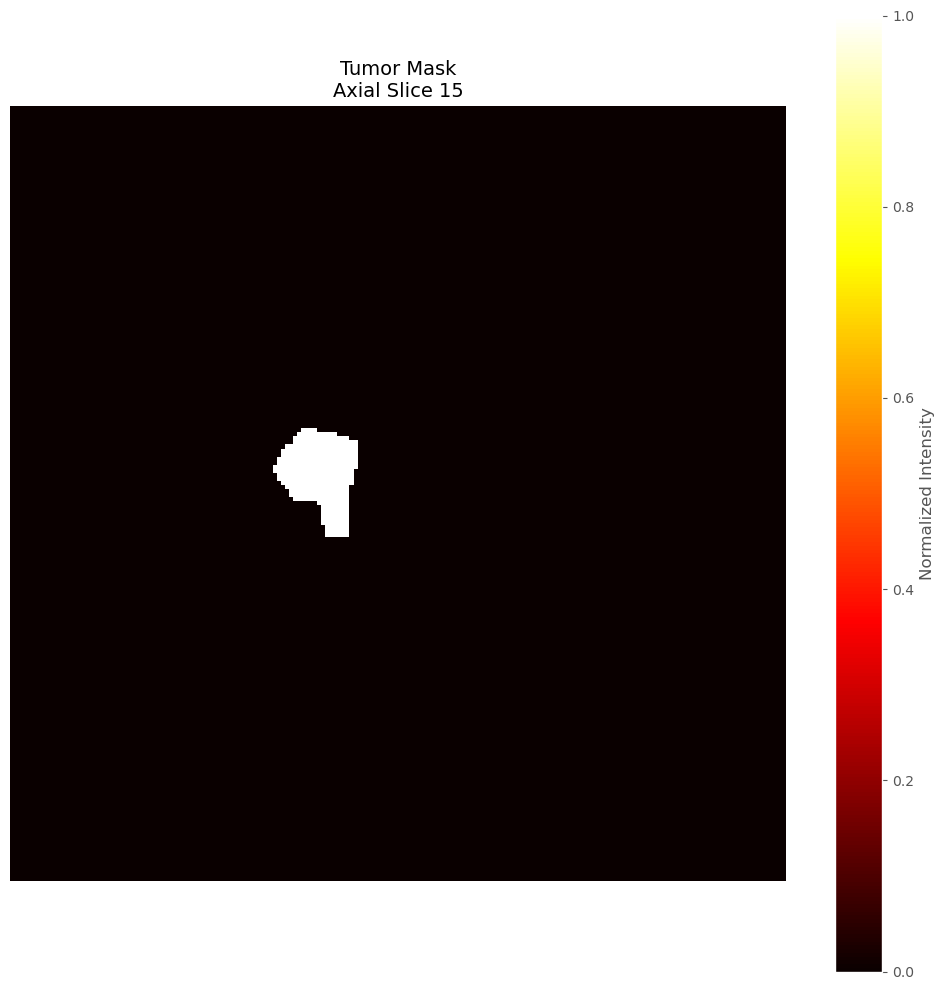


Displaying IVIM data with tumor mask overlay:


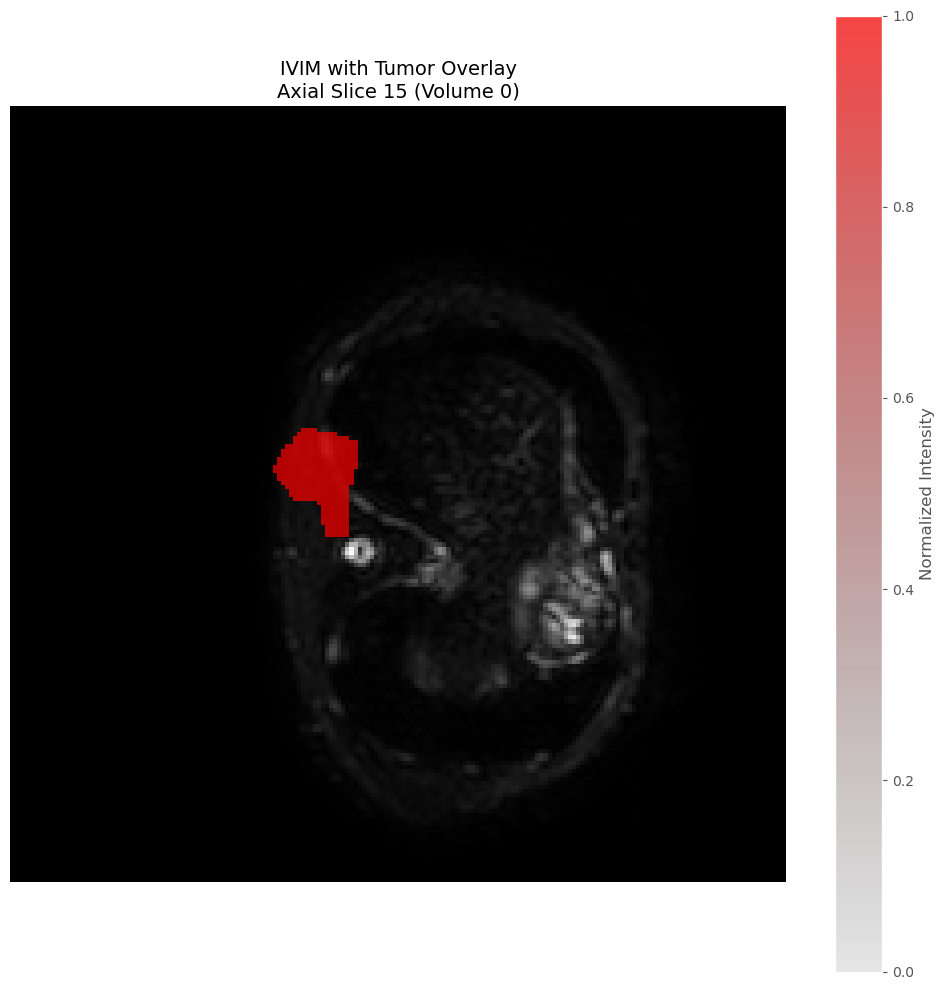

In [21]:
def display_slice(data, slice_index=None, axis=2, volume_index=0, title=None, 
                  cmap='gray', alpha=1.0, mask_overlay=None):
    """
    Display a slice from a 3D or 4D NIfTI data array with optional mask overlay
    
    Parameters:
        data (numpy.ndarray): The NIfTI data array
        slice_index (int): Index of the slice to display (default: middle slice)
        axis (int): Axis along which to take the slice (0=sagittal, 1=coronal, 2=axial)
        volume_index (int): For 4D data, which volume to use (default: 0)
        title (str): Optional title for the plot
        cmap (str): Colormap to use for the main image
        alpha (float): Transparency level for the main image
        mask_overlay (numpy.ndarray): Optional binary mask to overlay on the image
    """
    # Handle 4D data
    if len(data.shape) > 3:
        if volume_index >= data.shape[3]:
            print(f"Error: Volume index {volume_index} out of range (max: {data.shape[3]-1})")
            return
        data_3d = data[..., volume_index]
        volume_info = f" (Volume {volume_index})"
    else:
        data_3d = data
        volume_info = ""
    
    # Select the middle slice if not specified
    if slice_index is None:
        slice_index = data_3d.shape[axis] // 2
    
    # Get the orientation name and extract the slice
    orientations = ['Sagittal', 'Coronal', 'Axial']
    orientation = orientations[axis]
    
    if axis == 0:
        slice_data = data_3d[slice_index, :, :]
        if mask_overlay is not None:
            mask_slice = mask_overlay[slice_index, :, :]
    elif axis == 1:
        slice_data = data_3d[:, slice_index, :]
        if mask_overlay is not None:
            mask_slice = mask_overlay[:, slice_index, :]
    else:  # axis == 2 (default)
        slice_data = data_3d[:, :, slice_index]
        if mask_overlay is not None:
            mask_slice = mask_overlay[:, :, slice_index]
    
    # Normalize for better visualization
    if slice_data.max() > slice_data.min():
        norm_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min())
    else:
        norm_data = slice_data
    
    # Create figure
    plt.figure(figsize=(10, 10))
    
    # Display the slice
    plt.imshow(norm_data, cmap=cmap, alpha=alpha)
    
    # Overlay mask if provided
    if mask_overlay is not None:
        plt.imshow(mask_slice, cmap=red_cmap, interpolation='none')
    
    # Set title
    if title:
        plt.title(f"{title}\n{orientation} Slice {slice_index}{volume_info}", fontsize=14)
    else:
        plt.title(f"{orientation} Slice {slice_index}{volume_info}", fontsize=14)
    
    # Add colorbar and remove axis ticks
    plt.colorbar(label='Normalized Intensity')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Find the best slice to display the tumor (slice with most tumor voxels)
def find_best_tumor_slice(mask_data, axis=2):
    """Find the slice with the most tumor voxels"""
    tumor_voxel_counts = []
    
    for i in range(mask_data.shape[axis]):
        if axis == 0:
            slice_data = mask_data[i, :, :]
        elif axis == 1:
            slice_data = mask_data[:, i, :]
        else:  # axis == 2
            slice_data = mask_data[:, :, i]
        
        tumor_voxel_counts.append(np.sum(slice_data))
    
    best_slice = np.argmax(tumor_voxel_counts)
    return best_slice

# Find the best slice to view the tumor
best_tumor_slice = find_best_tumor_slice(tumor_data)
print(f"Best slice for viewing the tumor: {best_tumor_slice}")

# Display the tumor mask
print("\nDisplaying the tumor mask:")
display_slice(tumor_data, slice_index=best_tumor_slice, title="Tumor Mask", cmap='hot')

# Display the IVIM data with the tumor mask overlay
print("\nDisplaying IVIM data with tumor mask overlay:")
display_slice(ivim_data, slice_index=best_tumor_slice, volume_index=0, 
              title="IVIM with Tumor Overlay", mask_overlay=tumor_data)

In [10]:
# Create a function to apply a mask to extract data
def apply_mask(data, mask, binary=True):
    """
    Apply a mask to data to extract the region of interest
    
    Parameters:
        data (numpy.ndarray): The original data array
        mask (numpy.ndarray): The binary mask
        binary (bool): If True, treat mask as binary (non-zero = 1)
    
    Returns:
        numpy.ndarray: Data with mask applied (same shape as original)
    """
    # Make sure shapes match
    if data.shape[:3] != mask.shape:
        print(f"Error: Data shape {data.shape[:3]} doesn't match mask shape {mask.shape}")
        return None
    
    # Create a copy to avoid modifying original data
    masked_data = np.zeros_like(data)
    
    # If 4D data
    if len(data.shape) > 3:
        # For each volume
        for vol in range(data.shape[3]):
            # Convert mask to binary if needed
            binary_mask = mask > 0 if binary else mask
            
            # Apply the mask
            masked_data[..., vol] = data[..., vol] * binary_mask
    else:
        # Convert mask to binary if needed
        binary_mask = mask > 0 if binary else mask
        
        # Apply the mask
        masked_data = data * binary_mask
    
    return masked_data

# Apply the tumor mask to the IVIM data
ivim_masked = apply_mask(ivim_data, tumor_data)

print("Applied tumor mask to IVIM data")
print(f"Original IVIM data shape: {ivim_data.shape}")
print(f"Masked IVIM data shape: {ivim_masked.shape}")

# Count non-zero voxels in original and masked data
original_non_zero = np.count_nonzero(ivim_data)
masked_non_zero = np.count_nonzero(ivim_masked)

print(f"Non-zero voxels in original data: {original_non_zero:,}")
print(f"Non-zero voxels in masked data: {masked_non_zero:,}")
print(f"Percentage of voxels kept: {(masked_non_zero / original_non_zero) * 100:.4f}%")

# Display the masked data
print("\nDisplaying masked IVIM data (first volume):")
display_slice(ivim_masked, slice_index=best_tumor_slice, volume_index=0, 
              title="Masked IVIM Data (Tumor Region Only)")

# For comparison, show side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Extract the relevant slices
slice_original = ivim_data[:, :, best_tumor_slice, 0]
slice_mask = tumor_data[:, :, best_tumor_slice]
slice_masked = ivim_masked[:, :, best_tumor_slice, 0]

# Normalize for visualization
norm_original = (slice_original - slice_original.min()) / (slice_original.max() - slice_original.min())
norm_masked = (slice_masked - slice_masked.min()) / (slice_masked.max() - slice_masked.min()) if slice_masked.max() > slice_masked.min() else slice_masked

# Display images
axes[0].imshow(norm_original, cmap='gray')
axes[0].set_title('Original IVIM Image', fontsize=14)
axes[0].axis('off')

axes[1].imshow(slice_mask, cmap='hot')
axes[1].set_title('Tumor Mask', fontsize=14)
axes[1].axis('off')

axes[2].imshow(norm_masked, cmap='gray')
axes[2].set_title('Masked IVIM (Tumor Only)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

Error: Data shape (224, 224, 67) doesn't match mask shape (192, 192, 64)
Applied tumor mask to IVIM data
Original IVIM data shape: (224, 224, 67, 9)


AttributeError: 'NoneType' object has no attribute 'shape'

## 4. Extract Region of Interest (ROI)

Now, let's extract just the tumor region of interest and analyze it more thoroughly.
This involves:
1. Extracting only the voxels within the tumor mask
2. Creating a compact representation of the ROI
3. Visualizing the extracted ROI in multiple orientations

In [ ]:
# Function to extract ROI voxels
def extract_roi_voxels(data, mask):
    """
    Extract voxel values from the ROI defined by the mask
    
    Parameters:
        data (numpy.ndarray): The original data array 
        mask (numpy.ndarray): Binary mask defining the ROI
    
    Returns:
        numpy.ndarray: 1D array of voxel values in the ROI
    """
    # Make sure dimensions match
    if data.shape[:3] != mask.shape:
        print(f"Error: Data shape {data.shape[:3]} doesn't match mask shape {mask.shape}")
        return None
    
    # Create boolean mask
    bool_mask = mask > 0
    
    # For 4D data, return list of ROI arrays for each volume
    if len(data.shape) > 3:
        roi_voxels = []
        for vol in range(data.shape[3]):
            # Extract voxels where mask is True
            vol_data = data[..., vol]
            roi_voxels.append(vol_data[bool_mask])
        return roi_voxels
    else:
        # Extract voxels where mask is True
        return data[bool_mask]

# Function to get ROI bounding box
def get_roi_bbox(mask):
    """
    Get the bounding box coordinates of an ROI defined by a mask
    
    Parameters:
        mask (numpy.ndarray): Binary mask defining the ROI
    
    Returns:
        tuple: ((min_x, max_x), (min_y, max_y), (min_z, max_z)) bounding box coordinates
    """
    # Find non-zero coordinates
    coords = np.where(mask > 0)
    
    if len(coords[0]) == 0:  # No ROI found
        return None
    
    # Get min and max for each dimension
    x_min, x_max = np.min(coords[0]), np.max(coords[0])
    y_min, y_max = np.min(coords[1]), np.max(coords[1])
    z_min, z_max = np.min(coords[2]), np.max(coords[2])
    
    return ((x_min, x_max), (y_min, y_max), (z_min, z_max))

# Extract ROI voxels from each volume of the IVIM data
roi_voxels = extract_roi_voxels(ivim_data, tumor_data)

# Get information about the extracted ROI
print("=" * 70)
print("ROI EXTRACTION RESULTS".center(70))
print("=" * 70)

# For 4D data (multiple volumes)
if isinstance(roi_voxels, list):
    print(f"Extracted ROI voxels from {len(roi_voxels)} volumes")
    for i, vol_roi in enumerate(roi_voxels):
        print(f"\nVolume {i}:")
        print(f"• Number of voxels in ROI: {len(vol_roi):,}")
        print(f"• ROI value range: [{vol_roi.min():.3f}, {vol_roi.max():.3f}]")
        print(f"• ROI mean value: {vol_roi.mean():.3f}")
else:
    print(f"Number of voxels in ROI: {len(roi_voxels):,}")
    print(f"ROI value range: [{roi_voxels.min():.3f}, {roi_voxels.max():.3f}]")
    print(f"ROI mean value: {roi_voxels.mean():.3f}")

# Get and display bounding box
bbox = get_roi_bbox(tumor_data)
print("\nROI Bounding Box:")
print(f"X: {bbox[0][0]} to {bbox[0][1]} (width: {bbox[0][1] - bbox[0][0] + 1} voxels)")
print(f"Y: {bbox[1][0]} to {bbox[1][1]} (height: {bbox[1][1] - bbox[1][0] + 1} voxels)")
print(f"Z: {bbox[2][0]} to {bbox[2][1]} (depth: {bbox[2][1] - bbox[2][0] + 1} voxels)")

# Create a cropped version of the ROI for better visualization
def crop_to_roi(data, mask, padding=2):
    """
    Crop data and mask to the ROI bounding box with optional padding
    
    Parameters:
        data (numpy.ndarray): Original data
        mask (numpy.ndarray): Binary mask defining ROI
        padding (int): Number of voxels to pad around the ROI
        
    Returns:
        tuple: (cropped_data, cropped_mask)
    """
    # Get bounding box
    bbox = get_roi_bbox(mask)
    if bbox is None:
        return data, mask  # No ROI found
    
    # Extract limits with padding
    x_min = max(0, bbox[0][0] - padding)
    x_max = min(data.shape[0] - 1, bbox[0][1] + padding)
    y_min = max(0, bbox[1][0] - padding)
    y_max = min(data.shape[1] - 1, bbox[1][1] + padding)
    z_min = max(0, bbox[2][0] - padding)
    z_max = min(data.shape[2] - 1, bbox[2][1] + padding)
    
    # Crop the mask
    cropped_mask = mask[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    
    # Crop the data
    if len(data.shape) > 3:  # 4D data
        cropped_data = data[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1, :]
    else:  # 3D data
        cropped_data = data[x_min:x_max+1, y_min:y_max+1, z_min:z_max+1]
    
    return cropped_data, cropped_mask

# Crop the data and mask to the ROI with padding
cropped_ivim, cropped_mask = crop_to_roi(ivim_data, tumor_data, padding=5)

print("\nCropped ROI Dimensions:")
print(f"Original data shape: {ivim_data.shape}")
print(f"Cropped data shape: {cropped_ivim.shape}")
print(f"Cropped mask shape: {cropped_mask.shape}")

# Display the cropped ROI in all three orientations
print("\nDisplaying cropped ROI in three orientations:")

# Find middle slices in the cropped volume
mid_x = cropped_mask.shape[0] // 2
mid_y = cropped_mask.shape[1] // 2
mid_z = cropped_mask.shape[2] // 2

# Axial slice (most commonly used view)
display_slice(cropped_ivim, slice_index=mid_z, axis=2, volume_index=0, 
              title="ROI - Axial View", mask_overlay=cropped_mask)

# Sagittal slice
display_slice(cropped_ivim, slice_index=mid_x, axis=0, volume_index=0, 
              title="ROI - Sagittal View", mask_overlay=cropped_mask)

# Coronal slice
display_slice(cropped_ivim, slice_index=mid_y, axis=1, volume_index=0, 
              title="ROI - Coronal View", mask_overlay=cropped_mask)

## 5. Generate Histogram Analysis

Histograms provide valuable insights into the intensity distribution of an image or region of interest. 
They can help identify patterns, thresholds, and anomalies in the data.

In this section, we'll:
1. Generate histograms of the entire image and the ROI
2. Compare the intensity distributions
3. Test different histogram parameters (bins, normalization)

In [ ]:
# Function to create histograms with various options
def create_histogram(data, title="Histogram", bins=50, density=False, cumulative=False, 
                     log_scale=False, range=None, color='blue', alpha=0.7, figsize=(12, 6)):
    """
    Create a histogram with various options
    
    Parameters:
        data (numpy.ndarray): 1D array of values to plot
        title (str): Plot title
        bins (int): Number of bins
        density (bool): Whether to normalize the histogram
        cumulative (bool): Whether to create a cumulative histogram
        log_scale (bool): Whether to use log scale on y-axis
        range (tuple): Range of values to include (min, max)
        color (str): Bar color
        alpha (float): Transparency level
        figsize (tuple): Figure size
    """
    # Flatten the data if it's not already 1D
    if len(data.shape) > 1:
        data = data.flatten()
    
    # Remove zeros if log scale is used
    if log_scale:
        data = data[data > 0]
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Create histogram
    n, bins, patches = plt.hist(data, bins=bins, density=density, cumulative=cumulative, 
                                 range=range, color=color, alpha=alpha)
    
    # Add vertical lines for statistical measures
    plt.axvline(np.mean(data), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(data):.2f}')
    plt.axvline(np.median(data), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(data):.2f}')
    
    # Add log scale if requested
    if log_scale:
        plt.yscale('log')
    
    # Add labels and title
    plt.xlabel('Intensity Value')
    if density:
        plt.ylabel('Probability Density')
    elif cumulative:
        plt.ylabel('Cumulative Count')
    else:
        plt.ylabel('Frequency')
    
    plt.title(f"{title}\n{len(data):,} voxels, {bins} bins", fontsize=14)
    
    # Add statistics text box
    stats_text = f"Min: {np.min(data):.2f}\n" \
                f"Max: {np.max(data):.2f}\n" \
                f"Mean: {np.mean(data):.2f}\n" \
                f"Median: {np.median(data):.2f}\n" \
                f"Std Dev: {np.std(data):.2f}"
    
    plt.figtext(0.15, 0.7, stats_text, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return n, bins

# Create histograms for the first volume of IVIM data
volume_index = 0
volume_data = ivim_data[..., volume_index]

# Create histograms for the whole image and the ROI
print("=" * 70)
print("HISTOGRAM ANALYSIS".center(70))
print("=" * 70)

# Full image histogram
print("\nHistogram of the entire volume:")
volume_values = volume_data.flatten()
volume_values = volume_values[volume_values > 0]  # Remove zeros for better visualization
create_histogram(volume_values, title=f"Full Image (Volume {volume_index})", 
                 bins=100, color='blue', alpha=0.7)

# ROI histogram
print("\nHistogram of the tumor ROI:")
roi_values = roi_voxels[volume_index]
create_histogram(roi_values, title=f"Tumor ROI (Volume {volume_index})", 
                 bins=50, color='red', alpha=0.7)

# Comparison of histograms with different bin sizes
print("\nEffect of different bin sizes on histogram resolution:")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through different bin counts
for i, bin_count in enumerate([10, 50, 100]):
    axes[i].hist(roi_values, bins=bin_count, color='purple', alpha=0.7)
    axes[i].set_title(f"Tumor ROI - {bin_count} bins", fontsize=12)
    axes[i].set_xlabel('Intensity Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Normalized and cumulative histograms
print("\nNormalized histogram (probability density):")
create_histogram(roi_values, title=f"Tumor ROI - Normalized", 
                 bins=50, density=True, color='green')

print("\nCumulative histogram:")
create_histogram(roi_values, title=f"Tumor ROI - Cumulative", 
                 bins=50, cumulative=True, color='orange')

## 6. Calculate Statistical Parameters

Statistical parameters provide a quantitative way to describe the distribution of values within an ROI.
Common parameters include mean, median, standard deviation, variance, kurtosis, skewness, and percentiles.

In this section, we'll:
1. Calculate basic and advanced statistics for the ROI
2. Create a comprehensive statistical report
3. Visualize key statistical measures

In [11]:
# Function to calculate comprehensive statistics
def calculate_statistics(data, label="Data"):
    """
    Calculate comprehensive statistics for a dataset
    
    Parameters:
        data (numpy.ndarray): Array of values
        label (str): Name for the dataset
    
    Returns:
        dict: Dictionary containing all statistics
    """
    # Flatten data if needed
    if len(data.shape) > 1:
        data = data.flatten()
    
    # Basic statistics
    stats_dict = {
        'Label': label,
        'Count': len(data),
        'Min': np.min(data),
        'Max': np.max(data),
        'Range': np.max(data) - np.min(data),
        'Mean': np.mean(data),
        'Median': np.median(data),
        'Standard Deviation': np.std(data),
        'Variance': np.var(data),
        'Coefficient of Variation': (np.std(data) / np.mean(data)) if np.mean(data) != 0 else np.nan
    }
    
    # Higher-order statistics
    stats_dict['Skewness'] = stats.skew(data)
    stats_dict['Kurtosis'] = stats.kurtosis(data)
    
    # Information theory statistics
    # Calculate histogram for entropy
    hist, _ = np.histogram(data, bins=256)
    hist_norm = hist / hist.sum()
    hist_norm = hist_norm[hist_norm > 0]  # Remove zeros
    stats_dict['Entropy'] = -np.sum(hist_norm * np.log2(hist_norm))
    
    # Percentiles
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        stats_dict[f'{p}th Percentile'] = np.percentile(data, p)
    
    return stats_dict

# Calculate statistics for each volume in the ROI
roi_stats = []
for vol_idx, vol_roi in enumerate(roi_voxels):
    stats = calculate_statistics(vol_roi, label=f"ROI Volume {vol_idx}")
    roi_stats.append(stats)

# Create a DataFrame for easy viewing
stats_df = pd.DataFrame(roi_stats)

print("=" * 70)
print("STATISTICAL ANALYSIS".center(70))
print("=" * 70)

print("\nComprehensive statistics for tumor ROI:")
# Display the most important statistics
summary_stats = stats_df[['Label', 'Count', 'Min', 'Max', 'Mean', 'Median', 
                         'Standard Deviation', 'Skewness', 'Kurtosis', 'Entropy']]
display(summary_stats)

# Create a box plot to visualize the distribution across volumes
if len(roi_voxels) > 1:
    print("\nBox plot of ROI intensities across volumes:")
    plt.figure(figsize=(14, 8))
    
    # Prepare data for box plot
    box_data = roi_voxels
    
    # Create box plot
    plt.boxplot(box_data, labels=[f"Vol {i}" for i in range(len(roi_voxels))])
    plt.title("Distribution of Intensities Across Volumes", fontsize=14)
    plt.xlabel("Volume")
    plt.ylabel("Intensity Value")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create a violin plot for the first few volumes
if len(roi_voxels) > 1:
    print("\nViolin plot showing distribution details:")
    plt.figure(figsize=(14, 8))
    
    # Limit to first 5 volumes for clarity
    display_volumes = min(5, len(roi_voxels))
    violin_data = roi_voxels[:display_volumes]
    
    # Create violin plot
    plt.violinplot(violin_data, showmeans=True, showmedians=True)
    plt.title("Detailed Distribution of Intensities", fontsize=14)
    plt.xlabel("Volume")
    plt.ylabel("Intensity Value")
    plt.grid(True, alpha=0.3)
    plt.xticks(np.arange(1, display_volumes+1), [f"Vol {i}" for i in range(display_volumes)])
    plt.tight_layout()
    plt.show()

NameError: name 'roi_voxels' is not defined

## 7. Advanced Visualization Techniques

Advanced visualizations can provide deeper insights into the data distribution.
In this section, we'll explore:
1. Overlaying ROI on original images with different colormaps
2. Creating cumulative distribution functions (CDFs)
3. Generating Q-Q plots to assess normality
4. Creating 3D histograms for multi-volume analysis

In [12]:
# Function to create a Q-Q plot
def create_qq_plot(data, title="Q-Q Plot", figsize=(10, 10)):
    """
    Create a Q-Q plot to assess normality of data
    
    Parameters:
        data (numpy.ndarray): Data to analyze
        title (str): Plot title
        figsize (tuple): Figure size
    """
    plt.figure(figsize=figsize)
    
    # Create Q-Q plot
    stats.probplot(data, plot=plt)
    
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Function to create a CDF plot
def create_cdf_plot(data, title="Cumulative Distribution Function", color='blue', figsize=(12, 8)):
    """
    Create a CDF plot
    
    Parameters:
        data (numpy.ndarray): Data to analyze
        title (str): Plot title
        color (str): Line color
        figsize (tuple): Figure size
    """
    # Sort the data
    sorted_data = np.sort(data)
    
    # Calculate the CDF
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    plt.figure(figsize=figsize)
    plt.plot(sorted_data, cdf, marker='.', linestyle='none', alpha=0.5, color=color)
    plt.xlabel('Intensity Value')
    plt.ylabel('Cumulative Probability')
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Add lines for key percentiles
    percentiles = [25, 50, 75]
    for p in percentiles:
        value = np.percentile(data, p)
        plt.axvline(value, color='red', linestyle='--', alpha=0.7)
        plt.text(value, 0.02, f'{p}%', color='red')
    
    plt.tight_layout()
    plt.show()

# Let's create these advanced visualizations
print("=" * 70)
print("ADVANCED VISUALIZATIONS".center(70))
print("=" * 70)

# 1. Enhanced overlay with custom colormaps
print("\nEnhanced ROI overlay with custom colormap:")

# Create a more sophisticated overlay with a different colormap 
# for different tumor intensity levels
def create_enhanced_overlay(image_data, mask_data, slice_index=None, axis=2, volume_index=0, 
                           title="Enhanced Overlay", threshold=0.5):
    """Create an enhanced overlay with different tumor intensity levels"""
    # Prepare the data
    if len(image_data.shape) > 3:
        image_3d = image_data[..., volume_index]
        volume_info = f" (Volume {volume_index})"
    else:
        image_3d = image_data
        volume_info = ""
    
    # Select the middle slice if not specified
    if slice_index is None:
        slice_index = image_3d.shape[axis] // 2
    
    # Extract the slices
    if axis == 0:
        image_slice = image_3d[slice_index, :, :]
        mask_slice = mask_data[slice_index, :, :]
    elif axis == 1:
        image_slice = image_3d[:, slice_index, :]
        mask_slice = mask_data[:, slice_index, :]
    else:  # axis == 2
        image_slice = image_3d[:, :, slice_index]
        mask_slice = mask_data[:, :, slice_index]
    
    # Normalize image for display
    norm_image = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())
    
    # Create a multi-color overlay map
    # Non-tumor areas transparent, low intensity tumor in yellow, high intensity in red
    overlay = np.zeros((*mask_slice.shape, 4))  # RGBA
    
    # Areas with no tumor
    overlay[mask_slice == 0] = [0, 0, 0, 0]  # Transparent
    
    # Low intensity areas within tumor
    low_intensity = (mask_slice > 0) & (norm_image <= threshold)
    overlay[low_intensity] = [1, 1, 0, 0.7]  # Yellow, semi-transparent
    
    # High intensity areas within tumor
    high_intensity = (mask_slice > 0) & (norm_image > threshold)
    overlay[high_intensity] = [1, 0, 0, 0.7]  # Red, semi-transparent
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Display the base image
    plt.imshow(norm_image, cmap='gray')
    
    # Overlay the colored mask
    plt.imshow(overlay)
    
    # Get the orientation name for the title
    orientations = ['Sagittal', 'Coronal', 'Axial']
    orientation = orientations[axis]
    
    # Set title and labels
    plt.title(f"{title}\n{orientation} Slice {slice_index}{volume_info}", fontsize=14)
    plt.axis('off')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='yellow', alpha=0.7, label=f'Tumor (Intensity ≤ {threshold:.2f})'),
        Patch(facecolor='red', alpha=0.7, label=f'Tumor (Intensity > {threshold:.2f})')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Create enhanced overlay for the best tumor slice
create_enhanced_overlay(ivim_data, tumor_data, slice_index=best_tumor_slice, 
                      title="Tumor Intensity Levels", threshold=0.5)

# 2. Q-Q plot for ROI data (first volume)
print("\nQ-Q Plot to assess normality of ROI data:")
create_qq_plot(roi_voxels[0], title="Tumor ROI Q-Q Plot (Volume 0)")

# 3. CDF plot
print("\nCumulative Distribution Function (CDF) plot:")
create_cdf_plot(roi_voxels[0], title="Tumor ROI - CDF (Volume 0)")

# 4. 3D histogram for comparing multiple volumes (if available)
if len(roi_voxels) > 1:
    print("\n3D histogram comparing multiple volumes:")
    
    # Limit to first 3 volumes for clarity
    display_volumes = min(3, len(roi_voxels))
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = ['r', 'g', 'b', 'c', 'm']
    bin_counts = 30
    
    # Create histograms for each volume
    for i in range(display_volumes):
        hist, bins = np.histogram(roi_voxels[i], bins=bin_counts)
        xs = (bins[:-1] + bins[1:]) / 2  # Bin centers
        
        # Plot 3D bars
        width = 0.8 * (bins[1] - bins[0])
        depth = 0.8 / display_volumes
        
        # Offset bars for each volume
        offset = (i - display_volumes/2 + 0.5) * depth
        
        ax.bar3d(xs, [i+offset]*len(xs), [0]*len(xs), width, depth, hist, 
                 shade=True, color=colors[i % len(colors)], alpha=0.8,
                 label=f"Volume {i}")
    
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Volume Index')
    ax.set_zlabel('Frequency')
    ax.set_title('3D Histogram - ROI Intensities Across Volumes', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

                       ADVANCED VISUALIZATIONS                        

Enhanced ROI overlay with custom colormap:


ValueError: operands could not be broadcast together with shapes (192,192) (224,224) 

## 8. Compare Multiple ROIs

It's often valuable to compare different regions within the same image or across different images.
In this section, we'll:
1. Create a second ROI for comparison (using thresholding)
2. Compare statistics between ROIs
3. Create side-by-side visualizations

In [13]:
# Create a second ROI by thresholding
def create_threshold_roi(data, threshold, volume_index=0):
    """
    Create an ROI by thresholding the intensity values
    
    Parameters:
        data (numpy.ndarray): Original image data
        threshold (float): Threshold value
        volume_index (int): For 4D data, which volume to use
    
    Returns:
        numpy.ndarray: Binary mask of the thresholded region
    """
    # Get the 3D volume
    if len(data.shape) > 3:
        volume_data = data[..., volume_index]
    else:
        volume_data = data
    
    # Create the mask
    threshold_mask = volume_data > threshold
    
    return threshold_mask

print("=" * 70)
print("COMPARING MULTIPLE ROIS".center(70))
print("=" * 70)

# Create a second ROI using a threshold
# Let's find a good threshold value using the histogram
print("\nFinding appropriate threshold for second ROI...")

# Get first volume data for thresholding
volume_data = ivim_data[..., 0]

# Calculate a threshold based on percentile of non-zero values
non_zero = volume_data[volume_data > 0]
threshold = np.percentile(non_zero, 90)  # Use 90th percentile as threshold
print(f"Using threshold of {threshold:.4f} (90th percentile of non-zero values)")

# Create the threshold-based ROI
threshold_mask = create_threshold_roi(ivim_data, threshold, volume_index=0)

# Count voxels in the new ROI
threshold_roi_count = np.count_nonzero(threshold_mask)
print(f"New thresholded ROI contains {threshold_roi_count:,} voxels")

# Check overlap with tumor ROI
overlap_count = np.count_nonzero(threshold_mask & (tumor_data > 0))
tumor_count = np.count_nonzero(tumor_data)

print(f"Original tumor ROI contains {tumor_count:,} voxels")
print(f"Overlap between ROIs: {overlap_count:,} voxels")
print(f"Percentage of tumor ROI in threshold ROI: {overlap_count/tumor_count*100:.2f}%")
print(f"Percentage of threshold ROI in tumor ROI: {overlap_count/threshold_roi_count*100:.2f}%")

# Display both ROIs on the same slice
print("\nDisplaying both ROIs on the same slice:")

# Find a slice that shows both ROIs well
def find_best_slice_for_both_rois(roi1, roi2, axis=2):
    """Find a slice that best shows both ROIs"""
    combined_counts = []
    
    for i in range(roi1.shape[axis]):
        if axis == 0:
            roi1_slice = roi1[i, :, :]
            roi2_slice = roi2[i, :, :]
        elif axis == 1:
            roi1_slice = roi1[:, i, :]
            roi2_slice = roi2[:, i, :]
        else:  # axis == 2
            roi1_slice = roi1[:, :, i]
            roi2_slice = roi2[:, :, i]
        
        # Count voxels in both ROIs
        count1 = np.count_nonzero(roi1_slice)
        count2 = np.count_nonzero(roi2_slice)
        combined_counts.append(count1 + count2)
    
    return np.argmax(combined_counts)

best_slice = find_best_slice_for_both_rois(tumor_data, threshold_mask)
print(f"Best slice for viewing both ROIs: {best_slice}")

# Function to display multiple ROIs
def display_multiple_rois(data, rois, roi_names, slice_index, axis=2, volume_index=0, title="Multiple ROIs"):
    """
    Display multiple ROIs on the same slice with different colors
    
    Parameters:
        data (numpy.ndarray): Original image data
        rois (list): List of ROI masks
        roi_names (list): List of names for the ROIs
        slice_index (int): Index of the slice to display
        axis (int): Axis along which to take the slice
        volume_index (int): For 4D data, which volume to use
        title (str): Title for the plot
    """
    # Get the 3D volume
    if len(data.shape) > 3:
        volume_data = data[..., volume_index]
    else:
        volume_data = data
    
    # Get the slice
    if axis == 0:
        image_slice = volume_data[slice_index, :, :]
        roi_slices = [roi[slice_index, :, :] for roi in rois]
    elif axis == 1:
        image_slice = volume_data[:, slice_index, :]
        roi_slices = [roi[:, slice_index, :] for roi in rois]
    else:  # axis == 2
        image_slice = volume_data[:, :, slice_index]
        roi_slices = [roi[:, :, slice_index] for roi in rois]
    
    # Normalize image for display
    norm_image = (image_slice - image_slice.min()) / (image_slice.max() - image_slice.min())
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Display the base image
    plt.imshow(norm_image, cmap='gray')
    
    # Colors for different ROIs
    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan']
    
    # Create empty legend elements list
    legend_elements = []
    
    # Overlay each ROI with a different color
    for i, (roi_slice, name) in enumerate(zip(roi_slices, roi_names)):
        color = colors[i % len(colors)]
        
        # Create a colormap that goes from transparent to the ROI color
        cmap_colors = [(0, 0, 0, 0), (0, 0, 0, 0)]  # Both 0 and 1 are transparent initially
        if color == 'red':
            cmap_colors[1] = (1, 0, 0, 0.5)  # Semi-transparent red
        elif color == 'green':
            cmap_colors[1] = (0, 1, 0, 0.5)  # Semi-transparent green
        elif color == 'blue':
            cmap_colors[1] = (0, 0, 1, 0.5)  # Semi-transparent blue
        elif color == 'yellow':
            cmap_colors[1] = (1, 1, 0, 0.5)  # Semi-transparent yellow
        elif color == 'magenta':
            cmap_colors[1] = (1, 0, 1, 0.5)  # Semi-transparent magenta
        elif color == 'cyan':
            cmap_colors[1] = (0, 1, 1, 0.5)  # Semi-transparent cyan
        
        roi_cmap = LinearSegmentedColormap.from_list(f'custom_{color}', cmap_colors, N=256)
        
        # Display the ROI
        plt.imshow(roi_slice, cmap=roi_cmap)
        
        # Add to legend
        from matplotlib.patches import Patch
        legend_elements.append(Patch(facecolor=color, alpha=0.5, label=name))
    
    # Get the orientation name for the title
    orientations = ['Sagittal', 'Coronal', 'Axial']
    orientation = orientations[axis]
    
    # Set title and labels
    plt.title(f"{title}\n{orientation} Slice {slice_index}", fontsize=14)
    plt.axis('off')
    
    # Add the legend
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Display both ROIs
display_multiple_rois(ivim_data, 
                     [tumor_data, threshold_mask], 
                     ["Tumor ROI", "Threshold ROI"], 
                     best_slice, 
                     title="Comparison of Different ROIs")

# Extract voxels from the threshold ROI
threshold_roi_voxels = extract_roi_voxels(ivim_data[..., 0], threshold_mask)

# Compare histograms
print("\nComparing histograms between ROIs:")
fig, ax = plt.subplots(figsize=(14, 8))

# Plot histograms
ax.hist(roi_voxels[0], bins=50, alpha=0.5, label='Tumor ROI', color='red')
ax.hist(threshold_roi_voxels, bins=50, alpha=0.5, label='Threshold ROI', color='blue')

ax.set_title('Comparison of ROI Intensity Distributions', fontsize=14)
ax.set_xlabel('Intensity Value')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Compare statistics
print("\nComparing statistics between ROIs:")
tumor_stats = calculate_statistics(roi_voxels[0], label="Tumor ROI")
threshold_stats = calculate_statistics(threshold_roi_voxels, label="Threshold ROI")

# Create a DataFrame for comparison
comparison_df = pd.DataFrame([tumor_stats, threshold_stats])
comparison_columns = ['Label', 'Count', 'Min', 'Max', 'Mean', 'Median', 
                      'Standard Deviation', 'Skewness', 'Kurtosis']
display(comparison_df[comparison_columns])

# Create a bar chart comparing key metrics
metrics = ['Mean', 'Median', 'Standard Deviation', 'Skewness', 'Kurtosis']
roi_names = ['Tumor ROI', 'Threshold ROI']

# Prepare data for plotting
metrics_data = []
for metric in metrics:
    metrics_data.append([tumor_stats[metric], threshold_stats[metric]])

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(metrics))
width = 0.35

rects1 = ax.bar(x - width/2, [tumor_stats[m] for m in metrics], width, label='Tumor ROI', color='red', alpha=0.7)
rects2 = ax.bar(x + width/2, [threshold_stats[m] for m in metrics], width, label='Threshold ROI', color='blue', alpha=0.7)

ax.set_title('Comparison of Statistical Metrics Between ROIs', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        if abs(height) < 0.01:  # For very small values
            value_text = f"{height:.4f}"
        else:
            value_text = f"{height:.2f}"
        ax.annotate(value_text,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3 if height >= 0 else -3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=9)

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

                       COMPARING MULTIPLE ROIS                        

Finding appropriate threshold for second ROI...
Using threshold of 169.5043 (90th percentile of non-zero values)
New thresholded ROI contains 111,882 voxels


ValueError: operands could not be broadcast together with shapes (224,224,67) (192,192,64) 

## Conclusion

In this notebook, we've covered essential techniques for medical image analysis:

1. **Loading and Understanding Medical Images**: We loaded NIfTI files and understood their structure.
2. **Working with Tumor Masks**: We explored how to use binary masks to identify regions of interest.
3. **ROI Extraction**: We extracted tumor regions using masks and examined them in detail.
4. **Histogram Analysis**: We generated various histograms to analyze intensity distributions.
5. **Statistical Analysis**: We calculated comprehensive statistical parameters for ROIs.
6. **Advanced Visualizations**: We created enhanced visualizations including overlays and 3D histograms.
7. **Multiple ROI Comparison**: We compared different ROIs using side-by-side analysis.

These techniques are fundamental in medical image analysis for tasks such as tumor characterization, 
treatment planning, and response assessment.

In [14]:
# Final summary and potential next steps
print("=" * 70)
print("SUMMARY AND NEXT STEPS".center(70))
print("=" * 70)

print("""
This notebook demonstrated key techniques for medical image analysis with a focus on tumor ROI analysis.

Potential next steps:

1. Texture Analysis: Extract texture features from ROIs using methods like GLCM, GLRLM
2. Machine Learning: Use ROI features for classification or regression tasks
3. Time Series Analysis: For 4D data, analyze how ROIs change across volumes
4. Registration: Compare ROIs across different imaging sessions or modalities
5. Segmentation: Implement advanced automated segmentation methods
6. Shape Analysis: Quantify the morphology of ROIs
7. Functional Analysis: Examine how ROIs behave in functional imaging

These advanced techniques can provide deeper insights into medical imaging data
for research and clinical purposes.
""")

                        SUMMARY AND NEXT STEPS                        

This notebook demonstrated key techniques for medical image analysis with a focus on tumor ROI analysis.

Potential next steps:

1. Texture Analysis: Extract texture features from ROIs using methods like GLCM, GLRLM
2. Machine Learning: Use ROI features for classification or regression tasks
3. Time Series Analysis: For 4D data, analyze how ROIs change across volumes
4. Registration: Compare ROIs across different imaging sessions or modalities
5. Segmentation: Implement advanced automated segmentation methods
6. Shape Analysis: Quantify the morphology of ROIs
7. Functional Analysis: Examine how ROIs behave in functional imaging

These advanced techniques can provide deeper insights into medical imaging data
for research and clinical purposes.

